# Load data

In [1]:
import glob
import os
import numpy as np

In [2]:
all_files = glob.glob(os.path.join("data/lti_1d_trajectories", "*.csv"))

data = []
for file in all_files:
    data.append(np.loadtxt(file))
data_1d = np.array(data)

In [3]:
all_files = glob.glob(os.path.join("data/lti_2d_trajectories", "*.csv"))

data = []
for file in all_files:
    data.append(np.loadtxt(file))
data_2d = np.array(data)

# Some basic plots

In [4]:
import matplotlib.pylab as py

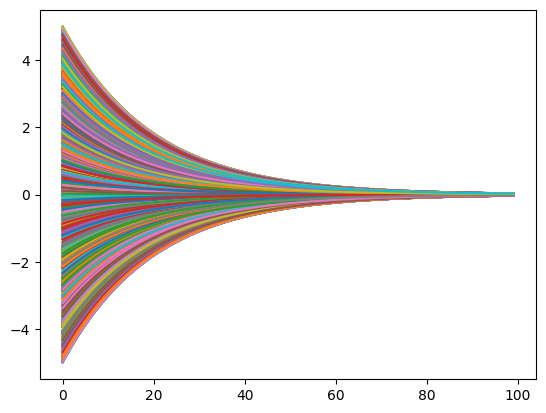

In [5]:
py.plot(data_1d.T);

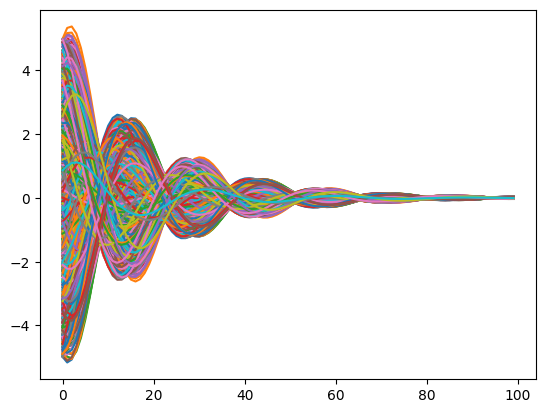

In [6]:
py.plot(data_2d.T);

# Auto-encoder

Based on https://www.kaggle.com/code/sinclairg/pytorch-lightning-tutorial-autoencoders

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl

/home/rcpaffenroth/projects/dac_raghu/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
encoder = nn.Sequential(nn.Linear(100, 64), 
                        nn.ELU(), 
                        nn.Linear(64, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 2))
decoder = nn.Sequential(nn.Linear(2, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 64),
                        nn.ELU(), 
                        nn.Linear(64, 100))

In [9]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Include extra logging here
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        return optimizer

In [10]:
ae = LitAutoEncoder(encoder, decoder)

In [11]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(data_2d))
train_loader = torch.utils.data.DataLoader(dataset)

In [12]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model=ae, train_dataloaders=train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rcpaffenroth/projects/dac_raghu/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/rcpaffenroth/projects/dac_raghu/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn

Epoch 9: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.04it/s, loss=0.000351, v_num=9]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.92it/s, loss=0.000351, v_num=9]


In [18]:
X =  torch.Tensor(data_2d)
H = encoder(X).detach()
X_hat = decoder(H).detach()

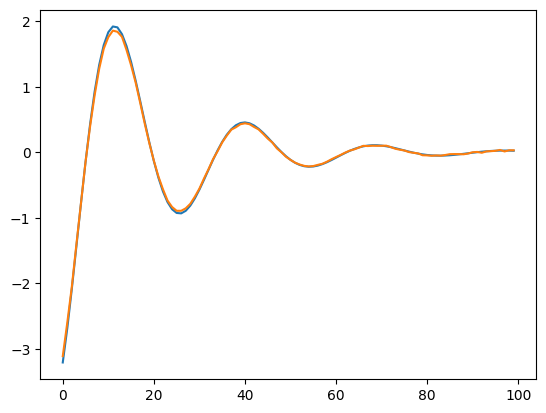

In [19]:
py.plot(X[0,:])
py.plot(X_hat[0,:])

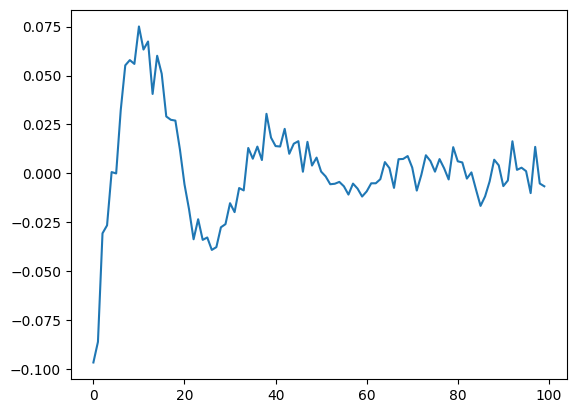

In [20]:
py.plot(X[0,:]-X_hat[0,:])

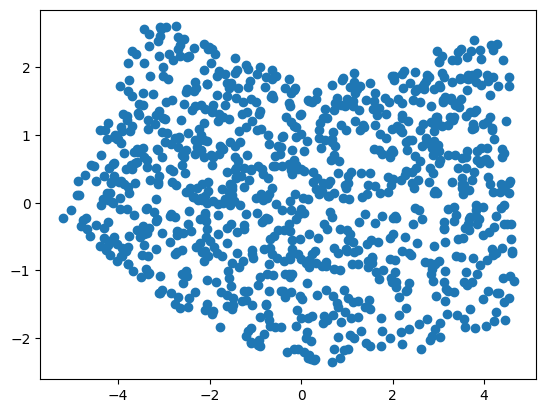

In [21]:
py.scatter(H[:,0], H[:,1])

tensor([ 2.8186, -2.0229], grad_fn=<AddBackward0>)


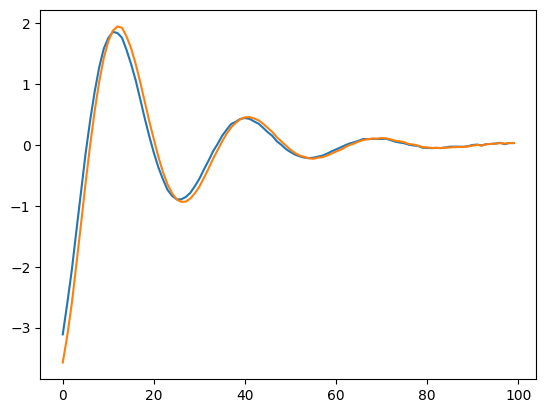

In [22]:
h = encoder(X[0,:])
print(h)
x_hat = decoder(h).detach()
py.plot(x_hat)

x_hat = decoder(h+torch.tensor([0.5, 0.5])).detach()
py.plot(x_hat)


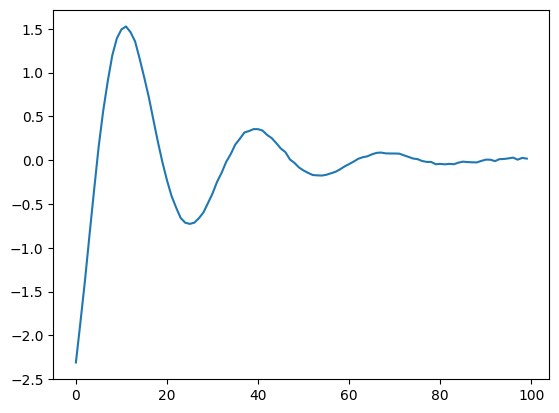

In [26]:
# h = torch.Tensor([2.8186, -2.0229])
h = torch.Tensor([2, -2])
x_hat = decoder(h).detach()
py.plot(x_hat)